## Get MAITE evaluate

__Description__:

This notebook demonstrates how to execute evaluations using HEART and MAITE's ```evaluate``` function

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load the data and model
3. Defending white-box attacks
4. Defending black-box attacks
5. Post-processing defense
6. Detection defence
7. Transformer defence
8. Adversarial training
9. Object detection task defence 
10. Conclusions and next steps

## 1. Notebook imports and utility functions

In [1]:
import torch
import numpy as np
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector
from heart_library.attacks.attack import JaticAttack

from datasets import load_dataset
from functools import partial
from datasets import Dataset
from torchvision.transforms import transforms

from art.attacks.evasion import ProjectedGradientDescent

import cv2
import matplotlib.pyplot as plt

import torch
from typing import Tuple, Dict, Any
from copy import deepcopy
from maite.tasks import evaluate
from heart_library.metrics import HeartMAPMetric



plt.style.use('ggplot')
%matplotlib inline

# visdrone_labels = ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']
visdrone_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [visdrone_labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 1.5
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()
    

class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, threshold=0.8):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.images)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = np.asarray(self.images[ind]["image"]).astype(np.float32)
        
        filtered_detection = self.groundtruth[ind]
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, None)

## 2. Load data

In [2]:
NUM_SAMPLES = 5

data = load_dataset("Voxel51/VisDrone2019-DET", split="train", streaming=True)
sample_data = data.take(NUM_SAMPLES)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

sample_data = Dataset.from_generator(partial(gen_from_iterable_dataset, sample_data), features=sample_data.features)

Resolving data files:   0%|          | 0/8632 [00:00<?, ?it/s]

#### Transform data

In [3]:
IMAGE_H, IMAGE_W = 800, 800

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

# data = data.take(NUM_SAMPLES)
# sample_data = data.map(lambda x: {"image": preprocess(x["image"]), "label": None})
# sample_data.info.features = data.info.features # t_sample_data = t_sample_data._resolve_features() # https://github.com/huggingface/datasets/issues/3888

sample_data = sample_data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

## 3. Define Object Detector

You can view the detections:
```python
for i, item in enumerate(sample_data):
    pred = vars(detections[i])
    preds_orig = extract_predictions(pred, 0.5)
    img = np.asarray(item['image'])
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
```

In [4]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                      device_type='cpu',
                                    input_shape=(3, 800, 800),
                                    clip_values=(0, 1), 
                                    attack_losses=("loss_ce",), 
                                    preprocessing=(MEAN, STD))

detections = detector(sample_data)

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


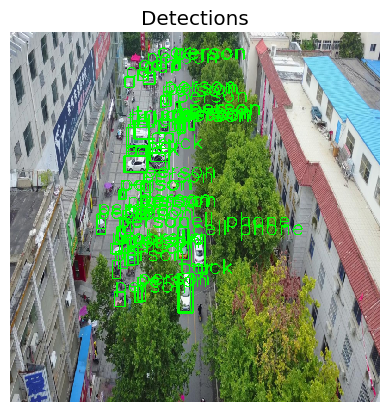

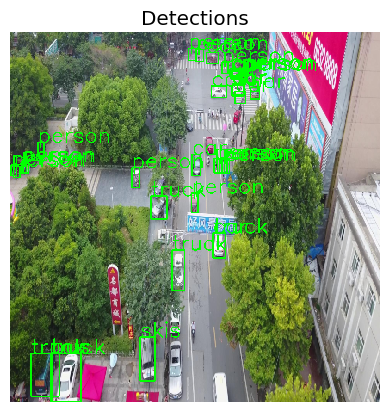

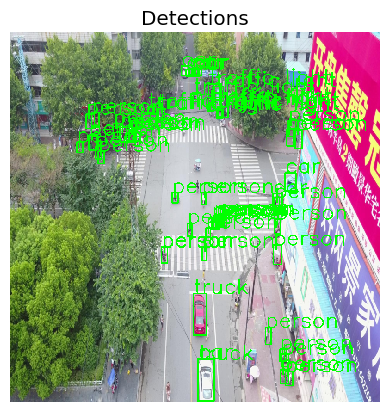

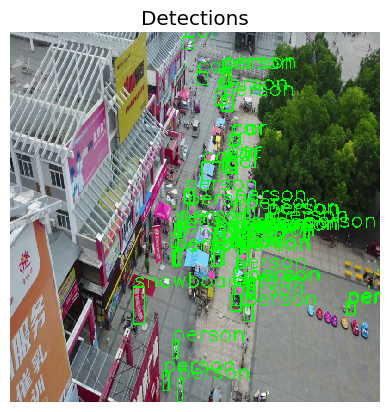

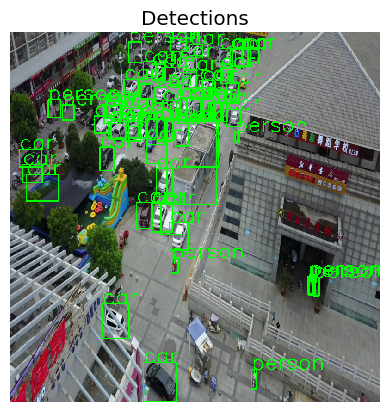

In [5]:
for i in range(len(sample_data)):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

Visualise the detections:
```python
for i in range(len(sample_data)):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
```

## 4. Define an adversarial attack
You can test this attack with the samplt data by executing the following:
```python

output = attack(sample_data_with_gt)
adv_images = output[0]

adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    pred = vars(adv_detections[i])
    preds_orig = extract_predictions(pred, 0.5)
    plot_image_with_boxes(img=adv_images[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
                          
```

In [6]:
from maite.protocols.object_detection import Dataset as od_dataset

attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=1, eps_step=0.01, eps=0.03, targeted=False, verbose=False), norm=2)

data_with_detections = ImageDataset(sample_data, deepcopy(detections), threshold=0.9)

assert isinstance(data_with_detections, od_dataset)

In [7]:
from maite.protocols.image_classification import Augmentation
isinstance(attack, Augmentation)

from maite.utils.validation import check_type
check_type('attack', attack, Augmentation)

## 5. Define the Metric and Evaluate (without attack)

In [8]:
map_args = {"box_format": "xyxy",
            "iou_type": "bbox",
            "iou_thresholds": [0.5],
            "rec_thresholds": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "max_detection_thresholds": [1, 10, 100],
            "class_metrics": False,
            "extended_summary": False,
            "average": "macro"}

In [9]:
from pprint import pprint
metric = HeartMAPMetric(**map_args)

results, _, metadata = evaluate(
    model=detector, 
    dataset=data_with_detections,
    metric=metric,
)

pprint(results)

  0%|          | 0/5 [00:00<?, ?it/s]

{'classes': tensor([ 1,  2,  3,  6,  8, 10, 15, 28, 35, 36, 77], dtype=torch.int32),
 'map': tensor(1.),
 'map_50': tensor(1.),
 'map_75': tensor(-1.),
 'map_large': tensor(-1.),
 'map_medium': tensor(1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(1.),
 'mar_1': tensor(0.6972),
 'mar_10': tensor(0.9674),
 'mar_100': tensor(1.),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(1.),
 'mar_small': tensor(1.)}


## 6. Evaluate with attack (augmentation)

In [10]:
results, _, _ = evaluate(
    model=detector, 
    dataset=data_with_detections,
    metric=metric,
    augmentation=attack,
)

pprint(results)

  0%|          | 0/5 [00:00<?, ?it/s]

{'classes': tensor([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 27, 28, 31, 56, 64],
       dtype=torch.int32),
 'map': tensor(0.1026),
 'map_50': tensor(0.1026),
 'map_75': tensor(-1.),
 'map_large': tensor(-1.),
 'map_medium': tensor(0.1450),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.2068),
 'mar_1': tensor(0.0109),
 'mar_10': tensor(0.1693),
 'mar_100': tensor(0.2702),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(0.3462),
 'mar_small': tensor(0.3429)}


#### Defended detector

In [11]:
from art.defences.preprocessor import JpegCompression

"""preprocessing_defense = SpatialSmoothingPyTorch(window_size=4, 
                                                clip_values=(0,1),
                                                channels_first=True,
                                                apply_predict=True
                                                )"""
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=75
                                        )

defended_detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                               device_type='cpu',
                                                input_shape=(3, 800, 800),
                                                clip_values=(0, 1), 
                                                attack_losses=( "loss_ce",), 
                                                preprocessing=(MEAN, STD),
                                                preprocessing_defences=[preprocessing_defense])

results, _, _ = evaluate(
    model=defended_detector, 
    dataset=data_with_detections,
    metric=metric,
    augmentation=attack,
)

pprint(results)

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main


  0%|          | 0/5 [00:00<?, ?it/s]

{'classes': tensor([ 1,  2,  3,  4,  6,  7,  8, 10, 27, 28], dtype=torch.int32),
 'map': tensor(0.2439),
 'map_50': tensor(0.2439),
 'map_75': tensor(-1.),
 'map_large': tensor(-1.),
 'map_medium': tensor(0.5115),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.2419),
 'mar_1': tensor(0.1040),
 'mar_10': tensor(0.5124),
 'mar_100': tensor(0.6351),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(0.9231),
 'mar_small': tensor(0.5048)}


## 6. Demo with Torchvision on Custom Model

#### Load the dataset with Torchvision and transform to dataloader

In [12]:
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from typing import Sequence, Tuple, Dict, Any
import numpy as np
import torch
from heart_library.attacks.attack import JaticAttack
from heart_library.metrics import HeartAccuracyMetric
from maite.tasks import evaluate
from maite.protocols.object_detection import Dataset as od_dataset


preprocess = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])

class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, data):
        self.data = data
    def __len__(self)->int:
        return len(self.data)
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Sequence[Dict[str, Any]]]:
        image, label = self.data.__getitem__(ind)
        return (image, label, [])

BS=3
data = torchvision.datasets.CIFAR10("../data/", train=False, transform=preprocess, download=True)
data = ImageDataset(data)

assert isinstance(data, od_dataset)

data = Subset(data, list(range(9)))
dl_train = DataLoader(data, batch_size=BS, drop_last=True, shuffle=True)

#### Define the custom model and wrap with HEART

In [13]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

import os
class Model(torch.nn.Module):
        """
        Create model for pytorch.
        Here the model does not use maxpooling. Needed for certification tests.
        """

        def __init__(self):
            super(Model, self).__init__()

            self.conv = torch.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
            )

            self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

            self.relu = torch.nn.ReLU()

            w_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            w_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )

            self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
            self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
            self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
            self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

        def forward(self, x):
            """
            Forward function to evaluate the model
            :param x: Input to the model
            :return: Prediction of the model
            """
            x = self.conv(x)
            x = self.relu(x)
            x = x.reshape(-1, 1600)
            x = self.fullyconnected(x)
            x = torch.nn.functional.softmax(x, dim=1)
            return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 1)
    
)

#### Define the attack

In [14]:
evasion_attack = ProjectedGradientDescentPyTorch(jptc, max_iter=100, eps_step=0.01, eps=0.03, targeted=False, verbose=False, batch_size=BS)
attack = JaticAttack(evasion_attack, norm=2)

#### Define the Accuracy Metric

In [15]:
acc_args = {
    "task": "multiclass", "num_classes": 10, "average":"macro"
}
metric = HeartAccuracyMetric(**acc_args)

#### Evaluate without attack

In [16]:
results, _, _ = evaluate(
    model=jptc, 
    dataloader=dl_train,
    metric=metric,
)

print('Accuracy:', results)

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: {'accuracy': 0.7333333492279053}


#### Evaluate with attack

In [17]:
results, _, augmented_data = evaluate(
    model=jptc, 
    dataloader=dl_train,
    metric=metric,
    augmentation=attack,
    return_augmented_data=True,
)

print('Accuracy:', results)

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: {'accuracy': 0.0}
